# DeepGaze IIE

In [1]:
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch

import deepgaze_pytorch

DEVICE = 'cuda'

# you can use DeepGazeI or DeepGazeIIE
model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

image = face()

centerbias_template = np.load('../../pretrained_weights/deepgaze/centerbias_mit1003.npy')
# rescale to match image size
centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
# renormalize log density
centerbias -= logsumexp(centerbias)

image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)
centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

log_density_prediction = model(image_tensor, centerbias_tensor)

/mnt/homes/minghao/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/homes/minghao/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded pretrained weights for efficientnet-b5


Using cache found in /mnt/homes/minghao/.cache/torch/hub/pytorch_vision_v0.6.0
/mnt/homes/minghao/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /mnt/homes/minghao/.cache/torch/hub/pytorch_vision_v0.6.0
/mnt/homes/minghao/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warning

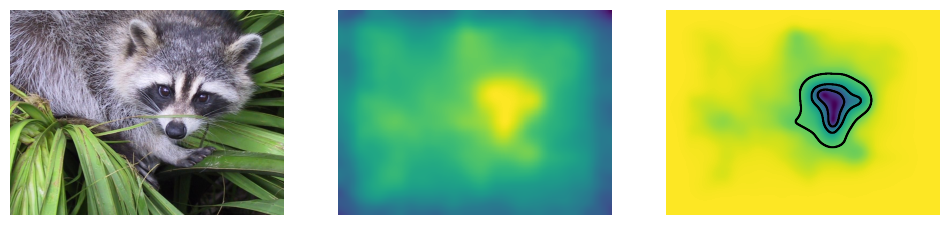

In [2]:
import matplotlib.pyplot as plt
from pysaliency.plotting import visualize_distribution

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
axs[0].imshow(image)
axs[0].set_axis_off()
axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])  # first image in batch, first (and only) channel
axs[1].set_axis_off()
visualize_distribution(log_density_prediction.detach().cpu().numpy()[0, 0], ax=axs[2])
axs[2].set_axis_off()

# DeepGaze III

Using cache found in /mnt/homes/minghao/.cache/torch/hub/pytorch_vision_v0.6.0
/tmp/ipykernel_2058020/2988869923.py:15: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  image = face()


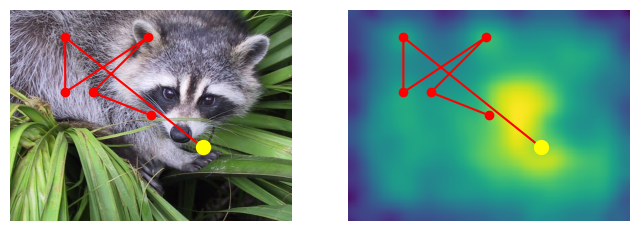

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch

import deepgaze_pytorch

DEVICE = 'cuda'

# you can use DeepGazeI or DeepGazeIIE
model = deepgaze_pytorch.DeepGazeIII(pretrained=True).to(DEVICE)

image = face()

# location of previous scanpath fixations in x and y (pixel coordinates), starting with the initial fixation on the image.
fixation_history_x = np.array([1024//2, 300, 500, 200, 200, 700])
fixation_history_y = np.array([768//2, 300, 100, 300, 100, 500])

# load precomputed centerbias log density (from MIT1003) over a 1024x1024 image
# you can download the centerbias from https://github.com/matthias-k/DeepGaze/releases/download/v1.0.0/../../pretrained_weights/deepgaze/centerbias_mit1003.npy
# alternatively, you can use a uniform centerbias via `centerbias_template = np.zeros((1024, 1024))`.
centerbias_template = np.load('../../pretrained_weights/deepgaze/centerbias_mit1003.npy')
# rescale to match image size
centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
# renormalize log density
centerbias -= logsumexp(centerbias)

image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)
centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)
x_hist_tensor = torch.tensor([fixation_history_x[model.included_fixations]]).to(DEVICE)
y_hist_tensor = torch.tensor([fixation_history_y[model.included_fixations]]).to(DEVICE)

log_density_prediction = model(image_tensor, centerbias_tensor, x_hist_tensor, y_hist_tensor)

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axs[0].imshow(image)
axs[0].plot(fixation_history_x, fixation_history_y, 'o-', color='red')
axs[0].scatter(fixation_history_x[-1], fixation_history_y[-1], 100, color='yellow', zorder=100)
axs[0].set_axis_off()
axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])  # first image in batch, first (and only) channel
axs[1].plot(fixation_history_x, fixation_history_y, 'o-', color='red')
axs[1].scatter(fixation_history_x[-1], fixation_history_y[-1], 100, color='yellow', zorder=100)
axs[1].set_axis_off()

In [5]:
from pysaliency.models import sample_from_logdensity

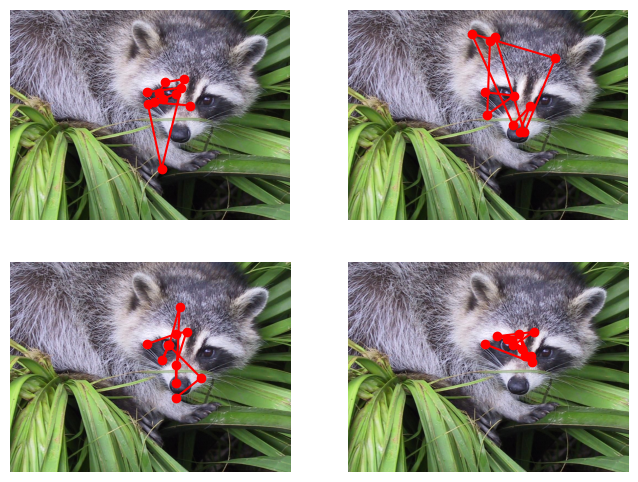

In [6]:
def get_fixation_history(fixation_coordinates, model):
    history = []
    for index in model.included_fixations:
        try:
            history.append(fixation_coordinates[index])
        except IndexError:
            history.append(np.nan)
    return history


f, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

rst = np.random.RandomState(seed=23)

for ax in axs.flatten():
    fixations_x = [500]
    fixations_y = [300]

    for i in range(10):
        x_hist = get_fixation_history(fixations_x, model)
        y_hist = get_fixation_history(fixations_y, model)

        
        x_hist_tensor = torch.tensor([x_hist]).to(DEVICE)
        y_hist_tensor = torch.tensor([y_hist]).to(DEVICE)
        log_density_prediction = model(image_tensor, centerbias_tensor, x_hist_tensor, y_hist_tensor)
        logD = log_density_prediction.detach().cpu().numpy()[0, 0]
        next_x, next_y = sample_from_logdensity(logD, rst=rst)

        fixations_x.append(next_x)
        fixations_y.append(next_y)

    ax.imshow(image)
    ax.plot(fixations_x, fixations_y, 'o-', color='red')
    ax.set_axis_off()

In [8]:
from typing import Optional, Tuple, List, Dict, Any, Union, Sequence
import pysaliency

class MySaliencyMapModel(pysaliency.SaliencyMapModel):
    
    def __init__(self, model_path, block_num=7, dst_w=720):
        super().__init__()
        self.model = deepgaze_pytorch.DeepGazeIII(pretrained=True).to(DEVICE)
        self.block_num = block_num
        self.dst_w = dst_w
        
    def _saliency_map(self, stimulus, text_description:Optional[str]=None):
        image = stimulus
        print(image.shape, image.dtype, np.min(image), np.max(image))
        plt.imshow(image)
        plt.show()
        
        image = face()
        print(image.shape, image.dtype, np.min(image), np.max(image))
        plt.imshow(image)
        plt.show()
        
        # location of previous scanpath fixations in x and y (pixel coordinates), starting with the initial fixation on the image.
        fixation_history_x = np.array([1024//2, 300, 500, 200, 200, 700])
        fixation_history_y = np.array([768//2, 300, 100, 300, 100, 500])

        # load precomputed centerbias log density (from MIT1003) over a 1024x1024 image
        # you can download the centerbias from https://github.com/matthias-k/DeepGaze/releases/download/v1.0.0/../../pretrained_weights/deepgaze/centerbias_mit1003.npy
        # alternatively, you can use a uniform centerbias via `centerbias_template = np.zeros((1024, 1024))`.
        centerbias_template = np.load('.../deepgaze/../../pretrained_weights/deepgaze/centerbias_mit1003.npy')
        # rescale to match image size
        centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
        # renormalize log density
        centerbias -= logsumexp(centerbias)

        image_tensor = torch.tensozr([image.transpose(2, 0, 1)]).to(DEVICE)
        centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)
        x_hist_tensor = torch.tensor([fixation_history_x[model.included_fixations]]).to(DEVICE)
        y_hist_tensor = torch.tensor([fixation_history_y[model.included_fixations]]).to(DEVICE)

        log_density_prediction = model(image_tensor, centerbias_tensor, x_hist_tensor, y_hist_tensor)

        f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
        axs[0].imshow(image)
        axs[0].plot(fixation_history_x, fixation_history_y, 'o-', color='red')
        axs[0].scatter(fixation_history_x[-1], fixation_history_y[-1], 100, color='yellow', zorder=100)
        axs[0].set_axis_off()
        axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])  # first image in batch, first (and only) channel
        axs[1].plot(fixation_history_x, fixation_history_y, 'o-', color='red')
        axs[1].scatter(fixation_history_x[-1], fixation_history_y[-1], 100, color='yellow', zorder=100)
        axs[1].set_axis_off()


2023-12-10 13:49:25.584 | INFO     | pysaliency.external_datasets.sjtuvis:get_description:63 - image_path:000000020777_2 | image_parts:['000000020777', '2']


{71: 'A passenger train glides around a curve on the outer track.', 77: 'A time lapse image of a guy on a skate board.', 165: "A woman soldier holding up a pair of giant scissors to someone's tie.", 263: 'Adult elephant pushing a baby elephant with its leg.', 312: 'A large group of elephants crossing a dirt path.', 338: 'Two people looking at a large kitchen ', 349: 'An old train drives on the tracks under a bridge. ', 400: 'Dog forlornly looking out the back of a twin-hulled boat.', 490: 'Dog and skateboard in a room and shadow of dog and person on a wall.', 510: 'A man sits on a bench with a man-made waterfall behind him. ', 520: 'Birds flock over a dock above a body of water.', 781: 'A person that is wind surfing in the water.', 908: 'A kitchen with art and a menu hanging on the wall', 939: 'Small bathroom with a mirror, double sink, and a mounted television. ', 999: 'A young man kneeling on top of a base.', 1011: 'People are walking along a sidewalk with their luggage.', 1053: 'A g

100%|██████████| 10/10 [00:00<00:00, 23.93it/s]


AUC wrt. shuffled nonfixations: 0.56


100%|██████████| 10/10 [00:00<00:00, 2733.87it/s]


AUC wrt. uniform nonfixations: 0.73


100%|██████████| 10/10 [00:00<00:00, 9362.29it/s]

AUC wrt. identical nonfixations: 0.50
Fixation based KL-divergence wrt. uniform nonfixations: 0.37
Fixation based KL-divergence wrt. shuffled nonfixations: 0.04
Fixation based KL-divergence wrt. identical nonfixations: 0.00


Image based KL-divergence: 1.0455509458954515 bit


0.0

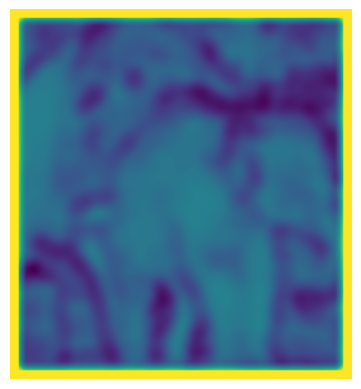

In [14]:
model_zoo = ['']


text_descriptor = TextDescriptor('../../datasets/test/original_sjtuvis_dataset/text.xlsx')
print(text_descriptor.get_description('000000020777_2.png')) 
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_sjtu_vis(location=data_location, text_descriptor=text_descriptor)
cutoff = 10
short_stimuli = pysaliency.FileStimuli(filenames=mit_stimuli.filenames[:cutoff])
short_fixations = mit_fixations[mit_fixations.n < cutoff]
aim = pysaliency.AIM(location='../../models', cache_location=os.path.join('model_caches', 'AIM'))
smap = aim.saliency_map(mit_stimuli[10])
print(smap.shape, np.min(smap), np.max(smap), np.mean(smap), np.std(smap), smap.dtype) 
plt.imshow(-smap)
plt.axis('off');
aim.AUC(short_stimuli, short_fixations, nonfixations='uniform', verbose=True)
print('AUC wrt. shuffled nonfixations: {:.02f}'.format(aim.AUC(short_stimuli, short_fixations, nonfixations='shuffled')))
aim.AUC(short_stimuli, short_fixations, nonfixations='shuffled', verbose=True)
print('AUC wrt. uniform nonfixations: {:.02f}'.format(aim.AUC(short_stimuli, short_fixations, nonfixations='uniform')))
aim.AUC(short_stimuli, short_fixations, nonfixations=short_fixations, verbose=True)
print('AUC wrt. identical nonfixations: {:.02f}'.format(aim.AUC(short_stimuli, short_fixations, nonfixations=short_fixations)))
perf = aim.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations='uniform')
print('Fixation based KL-divergence wrt. uniform nonfixations: {:.02f}'.format(perf))
perf = aim.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations='shuffled')
print('Fixation based KL-divergence wrt. shuffled nonfixations: {:.02f}'.format(perf))
perf = aim.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations=short_fixations)
print('Fixation based KL-divergence wrt. identical nonfixations: {:.02f}'.format(perf))
gold_standard = pysaliency.FixationMap(short_stimuli, short_fixations, kernel_size=30)
perf = aim.image_based_kl_divergence(short_stimuli, gold_standard)
print("Image based KL-divergence: {} bit".format(perf / np.log(2)))
gold_standard.image_based_kl_divergence(short_stimuli, gold_standard, minimum_value=1e-20)